# Trabajo Práctico 2: APIs y Web Scraping
## Alumnos: Manuel Díaz de la Fuente, Diego Fernández Mejide y Sofía Kastika
El objetivo del presente trabajo es la utilización de APIs y de Web Scraping. Para ello, en primer lugar se usará la API de Mercado Libre para un análisis exploratorio de precios de los productos y de items vendidos por ciertos productores. En segundo lugar, se utilizará la técnica de Web Scraping para tomar los links de las noticias de La Nación vigentes al momento de la realización del trabajo. 

## Parte A 

### Ejercicio 1
Usando la API de Mercado Libre, obtener los ítems de una consulta de búsqueda. Pueden buscar cualquier producto de su interés.

In [8]:
# Importamos los módulos requeridos para realizar el trabajo.
import requests
import pandas as pd
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup


In [10]:
# Establecemos el producto que queremos buscar
buscar = "Vinilo Art blakey and the jazz messengers"

# Creamos la url que vamos a buscar 
url = "https://api.mercadolibre.com/sites/{}/search?q={}".format("MLA", buscar.replace(" ", "%20"))
url
# Hacemos el pedido de información a la API
response = requests.request("GET", url)

# El pedido fue exitoso
print(response) 

# Convertimos la información a formato json
data = response.json()

# El resultado de la búsqueda incluye 39 productos
print('Longitud de lista de resultados:', len(data['results']))

<Response [200]>
Longitud de lista de resultados: 39


### Ejercicio 2
Guarden los precios de los ítems obtenidos en un dataframe y calculen el precio promedio, el mínimo y el máximo. 

In [15]:
# Definimos una función que toma el resultado de la búsqueda y me genera un diccionario con keys = nombre del producto y values = precio.
def buscador_precios(lista_diccionarios):
    nuevo_diccionario = {} # Crea un diccionario vacío
    for item in lista_diccionarios:
        # Aseguramos que ambos 'title' y 'price' estén en el diccionario
        if 'title' in item and 'price' in item:
            nuevo_diccionario[item['title']] = item['price']
    return nuevo_diccionario

# Creamos el diccionario con los precios.
lista_precios = buscador_precios(data['results'])

# Lo convertimos en un dataframe con la librería pandas.
lista_precios_df = pd.DataFrame.from_dict(lista_precios, orient='index', columns=['price']).reset_index()

# Renombramos la columna index porque es la columna de los nombres de los productos
lista_precios_df.rename(columns={'index': 'title'}, inplace=True)

# Calculamos el precio mínimo, máximo y el promedio
precio_minimo = min(lista_precios_df['price'])
print(precio_minimo)

precio_maximo = max(lista_precios_df['price'])
print(precio_maximo)

precio_promedio = lista_precios_df['price'].mean()
print(precio_promedio)


6500.0
153439.0
53627.92256410256


### Ejercicio 3
Armen un histograma de los precios usando Matplotlib. ¿Ven algún <i>outlier<i>? 

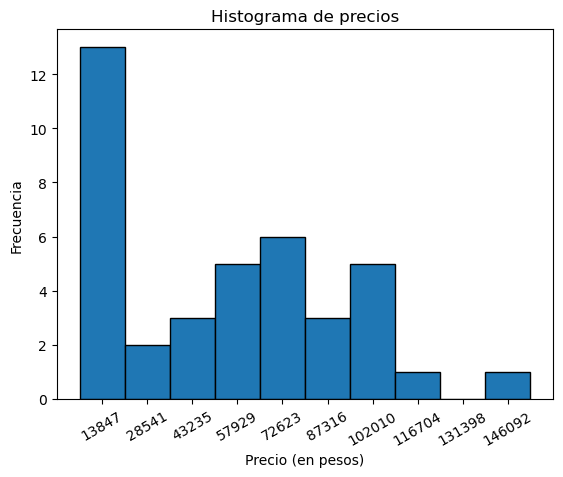

In [17]:
# Establecemos el número de bins y otros parámetros del histograma del histograma
n_bins = 10 
counts, bins, patches = plt.hist(lista_precios_df['price'], bins=n_bins, edgecolor='black')

# Calculamos las posiciones centrales de las barras
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Configuramos los ticks en el centro de las barras
plt.xticks(bin_centers, rotation = 30)

# Añadimos títulos y etiquetas
plt.title('Histograma de precios')
plt.xlabel('Precio (en pesos)')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.show()

# El gráfico sugiere la presencia de un outlier con precio entre de 140 mil y 150 mil pesos. 

### Ejercicio 4
Realicen alguna consulta adicional utilizando la API de Mercado Libre (debe ser alguna consulta que no se haya visto en clase. Por ejemplo, obtener los ítems de un vendedor en particular, obtener los productos de una categoría u otros). Analicen los resultados y comenten dos que les parezcan interesantes (por ejemplo, precios promedio de los productos de un vendedor, diferencia entre el precio original y actual, si acepta mercado pago para la compra de productos, etc.) 

## Parte B
### Ejercicio 5
De la página de noticias del diario La Nación, utilicen herramientas de web scraping para obtener los links de las noticias de la portada. Guarden los links obtenidos en un dataframe y expórtenlo a un archivo de excel.

#### Accediendo al contenido de la página de La Nación 

In [21]:
url = "https://www.lanacion.com.ar/" # Definimos URL
r = requests.get(url) # Traemos a la computadora el contenido html y lo almacenamos en 'r' 
contenido = r.content # Accedemos al contenido de r con .content (en formato bytes)
soup = BeautifulSoup(contenido, "html.parser") # Que se procese el contenido con el parser

#### Dentro de la sopa, buscamos los elementos que contienen la información que necesitamos: 

### Títulos de noticias

In [23]:
h2_elements = soup.find_all('h2') # Que encuentre en la sopa todos los elementos h2 
titulos = [] # Creamos una lista vacía para luego guardar los títulos ahí

# Armamos un for loop: 
for i in h2_elements: # Para cada elemento en h2_elements
    h2_text = i.text.strip() # Guardar al elemento como texto y sacando los espacios necesarios con .strip()
    titulos.append({  
        'titular': h2_text
    }) # Armamos un diccionario para cada elemento i en donde la key es 'titular' y el valor es 'h2_text' y los agregamos a la lista 'titulos'

#### Creamos un dataframe a partir de la lista de títulos 

In [25]:
titulos_df = pd.DataFrame(titulos) # Con esto tenemos un archivo con todos los titulares de la nación al momento 
titulos_df # Vemos los titulos

,titular
0,"El Presidente se refirió al caso Repsol, la ex..."
1,"""Me dabas sopapos y me dejabas la cara hirvien..."
2,Uno por uno. El Gobierno oficializó la reducci...
3,La electricidad del amor. Messi y las centella...
4,Alfaro mete a Paraguay. Así quedó la tabla de ...
...,...
132,“¿Por qué te viniste acá?”. La panadera aleman...
133,Día de la Alimentación. Todo lo que hay que te...
134,Descanso. A qué grupo de trabajadores le corre...
135,Cuenta regresiva. La fecha exacta para ver la ...


### Links de noticias 
En el caso de las noticias de la nación, las noticias tienen el tag 'a', y son de la clase 'link ln-link flex flex-column --unstyled' 

In [27]:
a_elements = soup.find_all('a', class_='link ln-link flex flex-column --unstyled') # Que encuentre en la sopa todos los elementos a con la clase mencionada. 

# Comentario: utilizamos class_ porque 'class' es una palabra protegida

links = [] # Creamos una lista vacía para luego guardar los links ahí
base_url = 'https://www.lanacion.com.ar'
# Armamos un for loop para extraer el href para cada link
for i in a_elements:
    href = i.get('href')  # Obtenemos el atributo href
    full_url = base_url + href 
    links.append({
        'link': full_url,
        })  # Armamos un diccionario para cada link y lo agrego a la lista 'links'


#### Creamos un dataframe a partir de la lista de links  

In [29]:
links_df = pd.DataFrame(links) # Con esto tenemos un archivo con todos los links de los titulos la nación al momento 
links_df # vemos los links

,link
0,https://www.lanacion.com.ar/politica/milei-dij...
1,https://www.lanacion.com.ar/politica/revelan-n...
2,https://www.lanacion.com.ar/economia/el-gobier...
3,https://www.lanacion.com.ar/deportes/futbol/me...
4,https://www.lanacion.com.ar/deportes/futbol/as...
...,...
132,https://www.lanacion.com.ar/revista-lugares/la...
133,https://www.lanacion.com.ar/lifestyle/dia-de-l...
134,https://www.lanacion.com.ar/feriados/2024/feri...
135,https://www.lanacion.com.ar/lifestyle/luna-del...


#### Ahora, vamos a unir los dataframes de los títulos de las noticias y sus links para que nos quede toda la información en un mismo dataframe

In [39]:
# Concatenamoss los dataframes por columna
result_df = pd.concat([titulos_df, links_df], axis=1)

# Cambiamos los títulos 
titulos_df.columns = ['Noticia']
links_df.columns = ['Link']

# Exportamos a excel 
result_df.to_excel("C:/Users/sofia/Desktop/Maestría/Tercer trimestre/Machine Learning/Trabajos-Pr-cticos/TP2/noticias.xlsx", index=False, engine='openpyxl')

### Screenshot noticias 16/10/2024 10.31 hs 

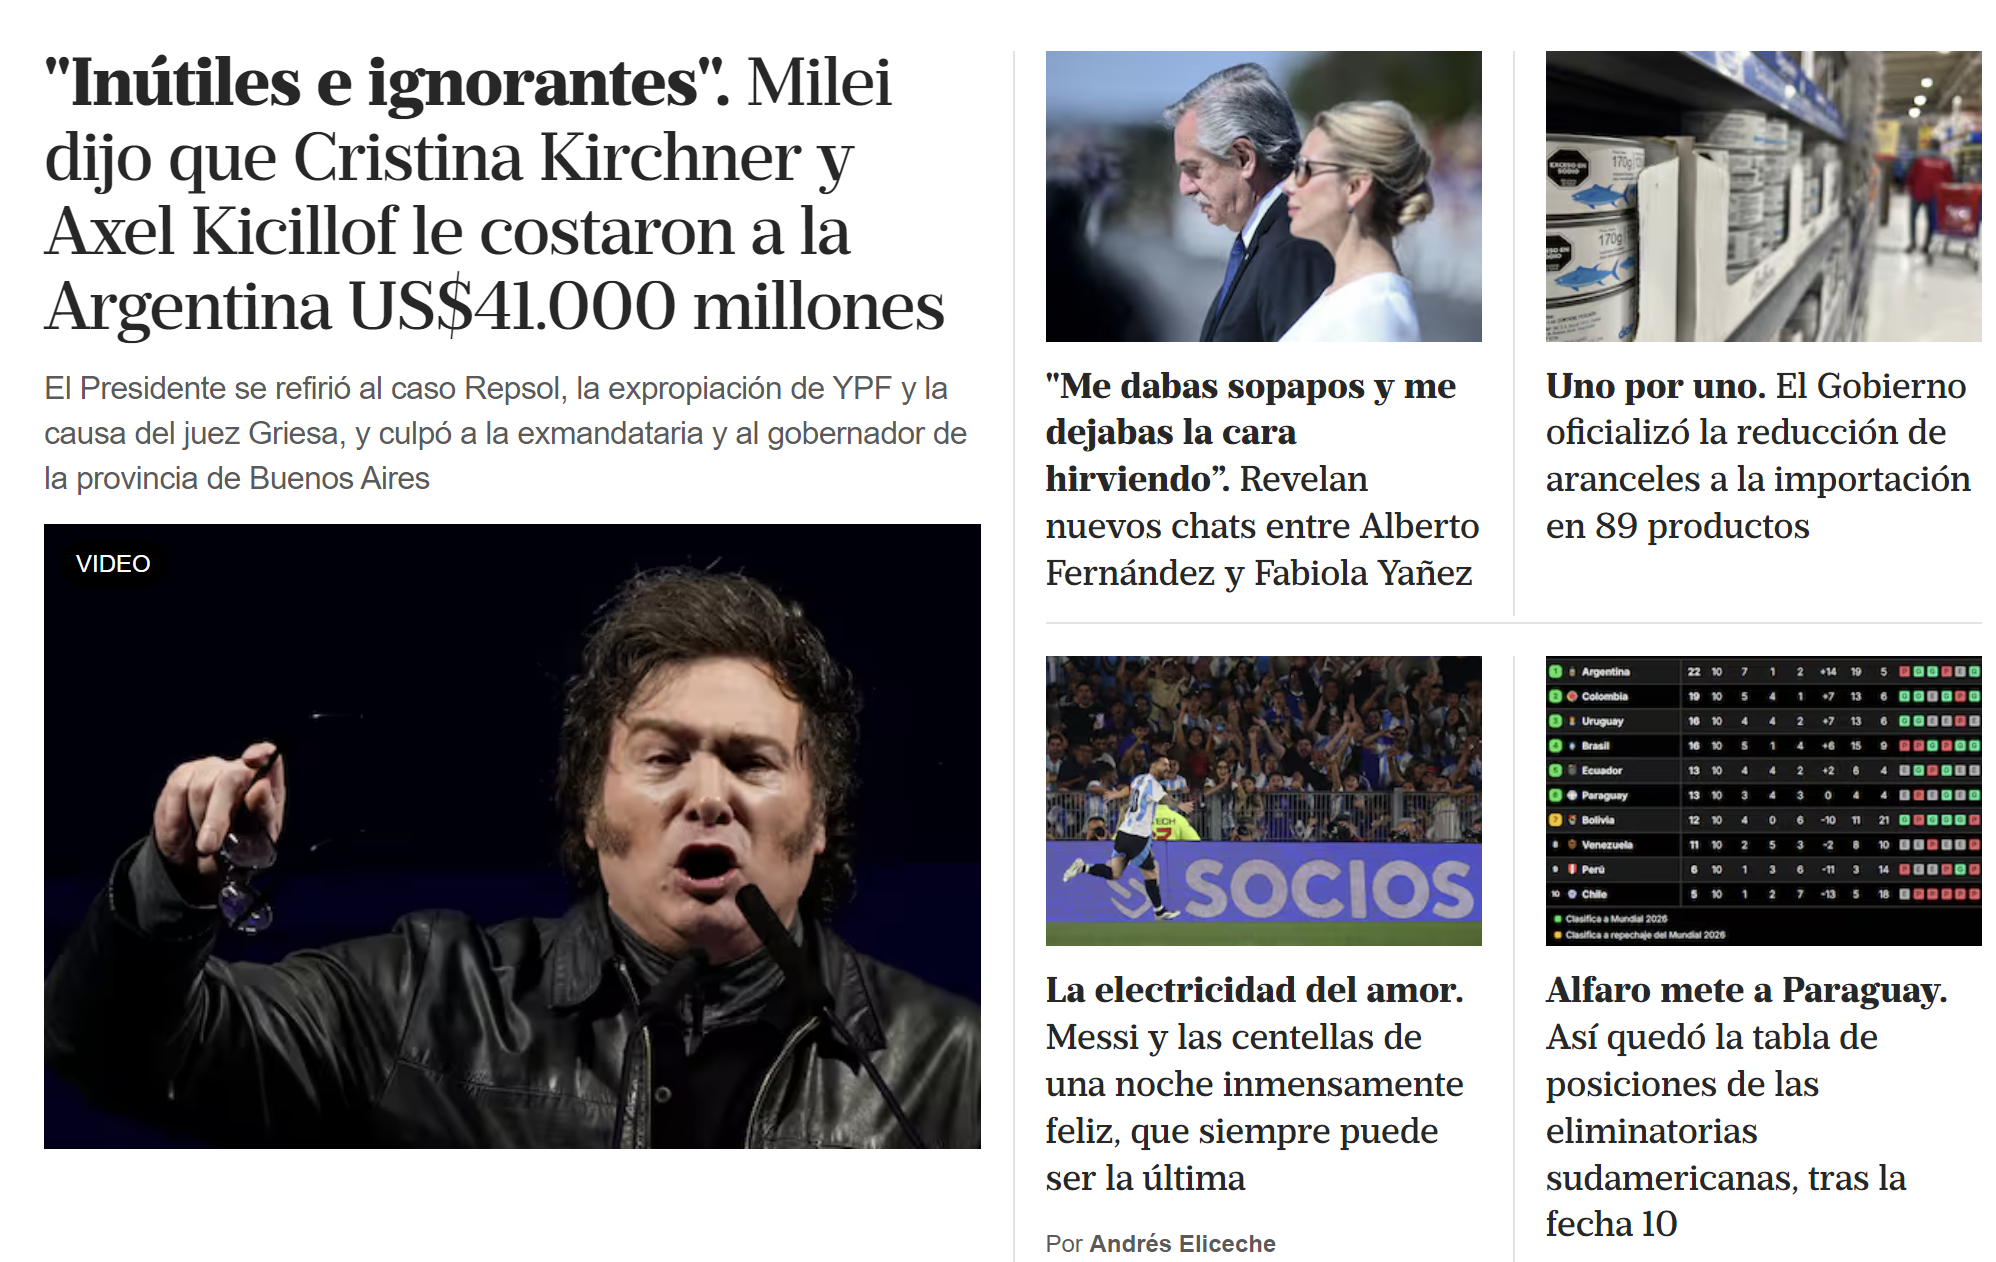

In [42]:
from IPython.display import Image # importamos paquete para subir imagen 

# Especificamos ruta de la imagen
Image(filename='screenshot.png')